# Technology focus: Xenium

This notebook will present an overview of the plotting functionalities of the `spatialdata` framework, in the context of a Xenium dataset.

Other notebooks, focused on data manipualtion, are also available for Xenium data:
- Alignment of a Xenium and Visium datasets (this is one of the reproducibility notebooks for the analysis of our paper) [notebook](https://github.com/scverse/spatialdata-notebooks/blob/main/notebooks/paper_reproducibility/00_xenium_and_visium.ipynb)
- Workflow showing saving annotations in Xenium Explorer and accessing them in SpaitalData, and viceversa [notebook](https://github.com/quentinblampey/spatialdata_xenium_explorer/blob/master/docs/10x_tutorials/xenium/xenium_tuto.ipynb). Tutorial from Quentin Blampey.

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

## Loading the data

A reader for Xenium data is available in `spatialdata-io`. We used it to parse and convert to Zarr a [Xenium dataset of Human Lung Cancer](https://www.10xgenomics.com/datasets/preview-data-ffpe-human-lung-cancer-with-xenium-multimodal-cell-segmentation-1-standard).

You can download the data from the link above, or from this [convenience python script](https://github.com/giovp/spatialdata-sandbox/blob/main/xenium_2.0.0_io/download.py) and convert it to spatialdata format with [this script](https://github.com/giovp/spatialdata-sandbox/blob/main/xenium_2.0.0_io/to_zarr.py), rename the `.zarr` store to `xenium.zarr` and place it in the current folder (in alternatively you can use symlinks to make the data visible).

The dataset used in this notebook is the latest Xenium Multimodal Cell Segmentation extension of the Xenium technology, available for data processed using Xenium Analyzer version 2.0.0 and when Cell Segmentation Kit was used. Nevertheless, the `xenium()` reader supports all the Xenium versions.

In [2]:
mouse_liver_path = "/Users/selman/projects/squidpy/docs/notebooks/examples/preprocessing/ignoreme_mouse_liver.zarr"

In [24]:
%%time
import spatialdata as sd
import spatialdata_plot  # noqa: F401

sdata = sd.read_zarr(mouse_liver_path)
sdata

CPU times: user 35.3 ms, sys: 11.8 ms, total: 47.2 ms
Wall time: 88.4 ms


/Users/selman/miniforge3/envs/squidpy/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


SpatialData object, with associated Zarr store: /Users/selman/projects/squidpy/docs/notebooks/examples/preprocessing/ignoreme_mouse_liver.zarr
├── Images
│     └── 'raw_image': DataTree[cyx] (1, 6432, 6432), (1, 1608, 1608)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (6432, 6432)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 3) (2D points)
├── Shapes
│     └── 'nucleus_boundaries': GeoDataFrame shape: (3375, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (3375, 99)
with coordinate systems:
    ▸ 'global', with elements:
        raw_image (Images), segmentation_mask (Labels), transcripts (Points), nucleus_boundaries (Shapes)

In [28]:
sdata["transcripts"], sdata["nucleus_boundaries"]

(Dask DataFrame Structure:
                      x        y               gene
 npartitions=1                                     
                float64  float64  category[unknown]
                    ...      ...                ...
 Dask Name: read-parquet, 1 graph layer,
                                                   geometry
 cell_ID                                                   
 99       POLYGON ((6277 798, 6277 799, 6272 799, 6272 8...
 142      POLYGON ((6427 6123, 6423 6123, 6423 6124, 641...
 208      POLYGON ((3747 858, 3747 859, 3746 859, 3746 8...
 235      POLYGON ((752 6144, 752 6145, 763 6145, 763 61...
 336      POLYGON ((5174 935, 5174 936, 5172 936, 5172 9...
 ...                                                    ...
 7652     POLYGON ((1094 6028, 1094 6029, 1091 6029, 109...
 7680     POLYGON ((1324 6063, 1324 6064, 1320 6064, 132...
 7694     POLYGON ((1692 6063, 1692 6064, 1686 6064, 168...
 7708     POLYGON ((768 6072, 768 6073, 765 6073, 765 60...
 772

In [29]:
points_gdf = points_dask_dataframe_to_geopandas(sdata.points["transcripts"])

In [30]:
points_gdf

,gene,geometry
0,Adgre1,POINT (433 1217)
1,Adgre1,POINT (151 1841)
2,Adgre1,POINT (139 1983)
3,Adgre1,POINT (1349 1601)
4,Adgre1,POINT (784 1732)
...,...,...
1153543,Lyve1,POINT (5743 5233)
1153544,Lyve1,POINT (5721 4581)
1153545,Lyve1,POINT (5807 4842)
1153546,Lyve1,POINT (5843 5309)


In [33]:
import spatialdata as sd
from spatialdata import SpatialData
from spatialdata.models._utils import (
    points_dask_dataframe_to_geopandas,
    points_geopandas_to_dask_dataframe,
)


def add_shape_membership_to_points(
    sdata: SpatialData,
    points_key: str = "transcripts",
    shapes_key: str = "nucleus_boundaries",
    shape_id_column: str = "cell_id",
    background_value: int = -1,
) -> SpatialData:
    """
    Add a column to the points table that indicates the shape membership of each point.
    """
    points = sdata.points[points_key]
    shapes_gdf = sdata.shapes[shapes_key]
    points_gdf = points_dask_dataframe_to_geopandas(points)
    res = points_gdf.sjoin(shapes_gdf, how="left", predicate="within")
    sdata.points[points_key] = points_geopandas_to_dask_dataframe(res)

    # res = res.drop(columns=["index_right"])
    # res = res.rename(columns={shape_id_column: "shape_id"})
    # res = res.fillna(background_value)
    # return res

In [34]:
a = add_shape_membership_to_points(sdata)

/Users/selman/projects/spatialdata/src/spatialdata/_core/_elements.py:118: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [35]:
sdata["transcripts"]

,x,y,gene,cell_ID
npartitions=1,,,,
0,float64,float64,category[known],string
1153547,...,...,...,...


/Users/selman/miniforge3/envs/squidpy/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/selman/miniforge3/envs/squidpy/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/selman/projects/spatialdata/src/spatialdata/_core/_elements.py:118: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                


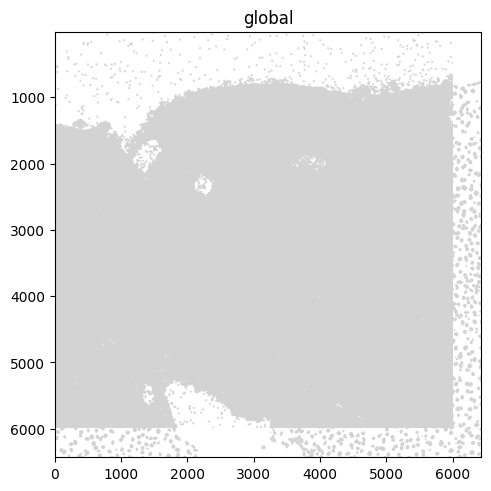

In [39]:
sdata.pl.render_points().pl.render_shapes().pl.show()